In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
import pandas as pd
import nltk
import numpy as np
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import scipy as sp
import os
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\prajw\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
project_data = pd.read_csv('DATA.csv')
project_data.drop(['Unnamed: 0'], axis=1, inplace=True)
y = project_data['label'].values
project_data.drop(['label'], axis=1, inplace=True)
X = project_data

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)


# Sentimental Features

## Train

In [4]:
Q = X_train["text"].copy()

cls = SentimentIntensityAnalyzer()

Positive_X_train_text = []
Negative_X_train_text = []

for i in (Q):
    n1= cls.polarity_scores(i)["neg"]
    n2= cls.polarity_scores(i)["pos"]
    Positive_X_train_text.append(n1)
    Negative_X_train_text.append(n2)
    

## Test

In [5]:
Q = X_test["text"].copy()

cls = SentimentIntensityAnalyzer()

Positive_X_test_text = []
Negative_X_test_text = []

for i in Q:
    n1= cls.polarity_scores(i)["neg"]
    n2= cls.polarity_scores(i)["pos"]
    Positive_X_test_text.append(n1)
    Negative_X_test_text.append(n2)
    

# N-grams 

### 2-grams

In [6]:
vectorizer = CountVectorizer(ngram_range = (2,2),max_features = 4000, min_df = 10)

X_train_preprocessed_text = X_train["text"]
X_test_preprocessed_text = X_test["text"]

X_train_2gram_features = vectorizer.fit_transform(X_train_preprocessed_text)
X_test_2gram_features = vectorizer.transform(X_test_preprocessed_text)

### 3-grams

In [7]:
vectorizer = CountVectorizer(ngram_range = (3,3),max_features = 4000, min_df = 10)

X_train_preprocessed_text = X_train["text"]
X_test_preprocessed_text = X_test["text"]

X_train_3gram_features = vectorizer.fit_transform(X_train_preprocessed_text)
X_test_3gram_features = vectorizer.transform(X_test_preprocessed_text)

### 2 grams & 3-grams combined

In [8]:
vectorizer = CountVectorizer(ngram_range = (2,3),max_features = 4000, min_df = 10)

X_train_preprocessed_text = X_train["text"]
X_test_preprocessed_text = X_test["text"]

X_train_2_3gram_features = vectorizer.fit_transform(X_train_preprocessed_text)
X_test_2_3gram_features = vectorizer.transform(X_test_preprocessed_text)

### 2 grams & 3-grams combined(TFIDF)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(2,3),min_df=10,max_features=4000)

X_train_preprocessed_text = X_train["text"]
X_test_preprocessed_text = X_test["text"]
T_train_2_3gram_features = vectorizer.fit_transform(X_train_preprocessed_text)
T_test_2_3gram_features = vectorizer.transform(X_test_preprocessed_text)

### Merging the features

### 2-gram

In [19]:
import numpy as np
Sentiment_X_train_text = np.column_stack((Positive_X_train_text, Negative_X_train_text))
Sentiment_X_test_text = np.column_stack((Positive_X_test_text, Negative_X_test_text))

In [20]:
X_train_2gram_array = X_train_2gram_features.toarray()
train_2_gram = np.concatenate((Sentiment_X_train_text, X_train_2gram_array), axis=1)
X_test_2gram_array = X_test_2gram_features.toarray()
test_2_gram = np.concatenate((Sentiment_X_test_text, X_test_2gram_array), axis=1)

### 3-grams

In [21]:
X_train_3gram_array = X_train_3gram_features.toarray()
train_3_gram = np.concatenate((Sentiment_X_train_text, X_train_3gram_array), axis=1)
X_test_3gram_array = X_test_3gram_features.toarray()
test_3_gram = np.concatenate((Sentiment_X_test_text, X_test_3gram_array), axis=1)

### 2 & 3 grams

In [22]:
X_train_2_3gram_array = X_train_2_3gram_features.toarray()
train_2_3gram = np.concatenate((Sentiment_X_train_text, X_train_2_3gram_array), axis=1)
X_test_2_3gram_array = X_test_2_3gram_features.toarray()
test_2_3gram = np.concatenate((Sentiment_X_test_text, X_test_2_3gram_array), axis=1)

### 2 & 3 grams(TFIDF)

In [23]:
T_train_2_3gram_array = X_train_2_3gram_features.toarray()
T_train_2_3gram = np.concatenate((Sentiment_X_train_text, T_train_2_3gram_array), axis=1)
T_test_2_3gram_array = X_test_2_3gram_features.toarray()
T_test_2_3gram = np.concatenate((Sentiment_X_test_text, T_test_2_3gram_array), axis=1)

### Models

### XGBoost with 2 grams

In [21]:
params = {
        'max_depth': [3, 4, 5, 6, 7, 8],
        'eta' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
        'n_estimators' : [100, 200, 300, 400, 500],
        'gamma': [0, 0.5, 1, 1.5, 2, 5]
        }

In [22]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)
xgb = XGBClassifier(nthread=1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=4, scoring='neg_log_loss', n_jobs=4, cv=skf.split(train_2_gram,y_train), verbose=2, random_state=42 )

random_search.fit(train_2_gram, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 45.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 45.1min finished


[23:20:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002D4D2BE8C80>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tr

In [27]:
print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best hyperparameters:
{'n_estimators': 500, 'max_depth': 7, 'gamma': 2, 'eta': 0.3}


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, cmap=cmap, fmt=".3f",  annot=True,annot_kws={"size": 14},xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B,  cmap=cmap, fmt=".3f", annot=True,annot_kws={"size": 14}, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A,  cmap=cmap, fmt=".3f", annot=True,annot_kws={"size": 14}, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Total number of test data points : 13934


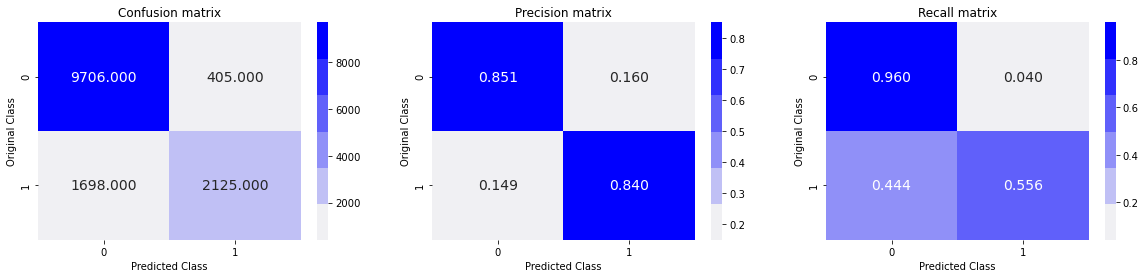

In [33]:
from sklearn.metrics import confusion_matrix
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBoost with 3-gram

In [36]:
params = {
        'max_depth': [3, 4, 5, 6, 7, 8],
        'eta' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
        'n_estimators' : [100, 200, 300, 400, 500],
        'gamma': [0, 0.5, 1, 1.5, 2, 5]
        }

In [37]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)
xgb = XGBClassifier(nthread=1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=4, scoring='neg_log_loss', n_jobs=4, cv=skf.split(train_3_gram,y_train), verbose=2, random_state=42 )


random_search.fit(train_3_gram, y_train)
 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 26.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 26.3min finished


[00:57:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002D4CEF0D580>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tr

In [38]:
print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best hyperparameters:
{'n_estimators': 500, 'max_depth': 7, 'gamma': 2, 'eta': 0.3}


In [39]:
import xgboost as xgb
from sklearn.metrics import log_loss
parameters = {}
parameters['objective'] = 'binary:logistic'
parameters['eval_metric'] = 'logloss'
parameters['eta'] = 0.3

parameters['max_depth'] = 7
parameters['n_estimators'] = 500
parameters['gamma'] = 2


d_train = xgb.DMatrix(train_3_gram, label= y_train)
d_test = xgb.DMatrix(test_3_gram, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(parameters, d_train, 400, watchlist, early_stopping_rounds=40, verbose_eval=10)

xgdmat = xgb.DMatrix(train_3_gram, y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y,  eps=1e-15))

[01:27:05] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.59298	valid-logloss:0.59446
[10]	train-logloss:0.41175	valid-logloss:0.42215
[20]	train-logloss:0.39675	valid-logloss:0.40984
[30]	train-logloss:0.38137	valid-logloss:0.39718
[40]	train-logloss:0.37272	valid-logloss:0.39001
[50]	train-logloss:0.36408	valid-logloss:0.38323
[60]	train-logloss:0.35947	valid-logloss:0.37984
[70]	train-logloss:0.35642	valid-logloss:0.37854
[80]	train-logloss:0.35244	valid-logloss:0.37594
[90]	train-logloss:0.34806	valid-logloss:0.37234
[100]	train-logloss:0.34082	valid-logloss:0.36661
[110]	train-logloss:0.33367	valid-logloss:0.36145
[120]	train-logloss:0.33116	valid-logloss:0.36012
[130]	train-logloss:0.33116	v

Total number of test data points : 13934


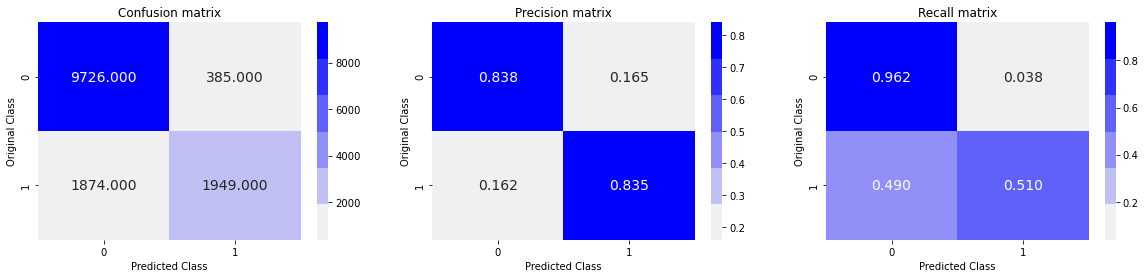

In [40]:
from sklearn.metrics import confusion_matrix
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBoost Combined (2 gram and 3 gram)

In [41]:
params = {
        'max_depth': [3, 4, 5, 6, 7, 8],
        'eta' : [0.01, 0.02, 0.05, 0.1, 0.2, 0.3],
        'n_estimators' : [100, 200, 300, 400, 500],
        'gamma': [0, 0.5, 1, 1.5, 2, 5]
        }

In [42]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)
xgb = XGBClassifier(nthread=1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=4, scoring='neg_log_loss', n_jobs=4, cv=skf.split(train_2_3gram,y_train), verbose=2, random_state=42 )


random_search.fit(train_2_3gram, y_train)
 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 38.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 38.8min finished


[02:18:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002D4D767C0B0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tr

In [43]:
print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best hyperparameters:
{'n_estimators': 500, 'max_depth': 7, 'gamma': 2, 'eta': 0.3}


In [44]:
import xgboost as xgb
from sklearn.metrics import log_loss
parameters = {}
parameters['objective'] = 'binary:logistic'
parameters['eval_metric'] = 'logloss'
parameters['eta'] = 0.3

parameters['max_depth'] = 7
parameters['n_estimators'] = 500
parameters['gamma'] = 2


d_train = xgb.DMatrix(train_3_gram, label= y_train)
d_test = xgb.DMatrix(test_3_gram, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(parameters, d_train, 400, watchlist, early_stopping_rounds=40, verbose_eval=10)

xgdmat = xgb.DMatrix(train_3_gram, y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y,  eps=1e-15))

[02:42:03] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.59298	valid-logloss:0.59446
[10]	train-logloss:0.41175	valid-logloss:0.42215
[20]	train-logloss:0.39675	valid-logloss:0.40984
[30]	train-logloss:0.38137	valid-logloss:0.39718
[40]	train-logloss:0.37272	valid-logloss:0.39001
[50]	train-logloss:0.36408	valid-logloss:0.38323
[60]	train-logloss:0.35947	valid-logloss:0.37984
[70]	train-logloss:0.35642	valid-logloss:0.37854
[80]	train-logloss:0.35244	valid-logloss:0.37594
[90]	train-logloss:0.34806	valid-logloss:0.37234
[100]	train-logloss:0.34082	valid-logloss:0.36661
[110]	train-logloss:0.33367	valid-logloss:0.36145
[120]	train-logloss:0.33116	valid-logloss:0.36012
[130]	train-logloss:0.33116	v

Total number of test data points : 13934


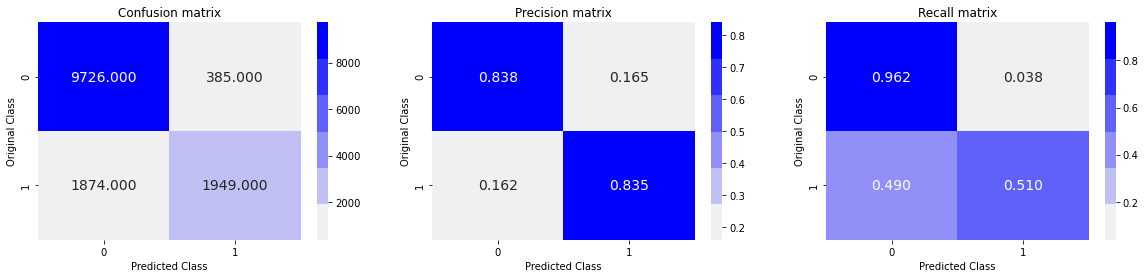

In [45]:
from sklearn.metrics import confusion_matrix
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### TFIDF

In [48]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)
xgb = XGBClassifier(nthread=1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=4, scoring='neg_log_loss', n_jobs=4, cv=skf.split(T_train_2_3gram,y_train), verbose=2, random_state=42 )


random_search.fit(T_train_2_3gram, y_train)
 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 26.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 26.8min finished


[03:21:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002D4D767CEB0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tr

In [49]:
print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best hyperparameters:
{'n_estimators': 500, 'max_depth': 7, 'gamma': 2, 'eta': 0.3}


In [50]:
import xgboost as xgb
from sklearn.metrics import log_loss
parameters = {}
parameters['objective'] = 'binary:logistic'
parameters['eval_metric'] = 'logloss'
parameters['eta'] = 0.3

parameters['max_depth'] = 7
parameters['n_estimators'] = 500
parameters['gamma'] = 2


d_train = xgb.DMatrix(T_train_2_3gram, label= y_train)
d_test = xgb.DMatrix(T_test_2_3gram, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(parameters, d_train, 400, watchlist, early_stopping_rounds=40, verbose_eval=10)

xgdmat = xgb.DMatrix(T_train_2_3gram, y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y,  eps=1e-15))

[11:12:12] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.58327	valid-logloss:0.58548
[10]	train-logloss:0.39581	valid-logloss:0.41273
[20]	train-logloss:0.37597	valid-logloss:0.39782
[30]	train-logloss:0.35630	valid-logloss:0.38303
[40]	train-logloss:0.34742	valid-logloss:0.37715
[50]	train-logloss:0.33865	valid-logloss:0.37226
[60]	train-logloss:0.32511	valid-logloss:0.36136
[70]	train-logloss:0.32041	valid-logloss:0.35936
[80]	train-logloss:0.31365	valid-logloss:0.35487
[90]	train-logloss:0.30994	valid-logloss:0.35362
[100]	train-logloss:0.30675	valid-logloss:0.35216
[110]	train-logloss:0.29597	valid-logloss:0.34461
[120]	train-logloss:0.29597	valid-logloss:0.34461
[130]	train-logloss:0.29597	v

Total number of test data points : 13934


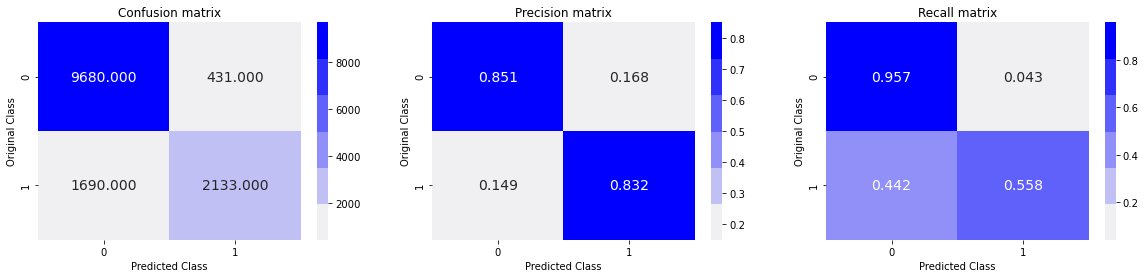

In [51]:
from sklearn.metrics import confusion_matrix
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of test data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)